## **Main Script for processing 2-photon imaging data**
#### **Suite2p registration and cell selection must be completed prior to running this script**
- **Section 1**: Process fluorescence traces and calculate dff and deconv activity traces 

- **Section 2**: Align the imaging data with virmen trials and save the imaging trial struct

- **Section 3**: Find spiral times and targets
    - Requires Fall and Fall_red cell selection to be done

- **Section 4**: Create trial structure and calculate influence
    - Requires section 3 to be completed
    

## **Section 0 : Import classes, and dataset specific values**

#### **0.1 -** Load local functions and static variables

In [1]:
# MUST BE RUN FIRST
import numpy as np
import os 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy import stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ranksums
from scipy.signal import find_peaks
from numba import jit, prange
import matplotlib as mpl
import random
import pickle
import gzip
from pathlib import Path
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2
import hdf5storage
from neo.io import AxonIO
import platform

# IMPORTS: MUST BE RUN FIRST
# Core scientific packages
import numpy as np
import matplotlib.pyplot as plt

# File and path handling
import os
import glob

from tkinter import filedialog
import tkinter as tk
import pyabf
from skimage import measure
import xml.etree.ElementTree as ET
from scipy import signal as sig

# Neural imaging
import suite2p as s2p

# Import our analysis class
from process_spirals import GalvoTargetAnalysis

import ipympl
# Configure matplotlib for inline plotting in notebook
%matplotlib widget


c:\Users\RUNYAN1\AppData\Local\anaconda3\envs\neural_analysis\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
# LOCAL FUNCTIONS & STATIC VARIABLES
def create_info_dict(mouseID, date, full_server,experimenter,sync_name,initials,virmen_channel,imaging_channel):
    """
    Creates info dictionary from mouseID and date.
    
    Args:
        mouseID (str): Mouse identifier (e.g., 'IS-3-1R')
        date (str): Date in format 'YYYY-MM-DD'
    """
    # Convert YYYY-MM-DD to YYMMDD for virmen path
    short_date = date[2:].replace('-', '')  # Takes '2024-10-29' -> '241029'
    short_mouse = mouseID[:2]
    short_mouse = short_mouse + mouseID[3]
    
    info = {
        "mousename": mouseID,
        "mouse": mouseID,
        "date": date,
        "server": full_server,
        "experimenter_name": {experimenter},
        #"sync_base_path": f"\{full_server}\{experimenter}\RawData\{mouseID}\{sync_name}\{date}",
        "sync_base_path": f"{full_server}\{experimenter}\{sync_name}\{mouseID}\{date}",
        "virmen_base": f"{full_server}\{experimenter}\RawData\{mouseID}\\virmen\{initials}{short_mouse}_{short_date}",
        "imaging_base_path": f"{full_server}\{experimenter}\RawData\{mouseID}\{date}\TSeries",
        "save_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}",
        "processed_path": f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes",
        "is_stim_dataset": 1,
        "galvo_channel": imaging_channel, # 7 
        "virmen_channel": virmen_channel, # 5 
        "vr_sync_string": "sync_"
    }
    return info
def save_imaging_data(imaging_dict, save_path):
    """
    Save the imaging dictionary and create a list of trials with imaging data
    
    Args:
        imaging_dict (dict): Dictionary containing trial data
        save_path (str): Path where to save the files
    
    Returns:
        list: List of trial numbers that have imaging data
    """
    import pickle
    
    # Find trials with imaging data
    imaged_trials = []
    for trial_key, trial_data in imaging_dict.items():
        # Check if either deconv or dff contains data (is not None and not empty)
        if (('deconv' in trial_data and trial_data['deconv'] is not np.NaN and 
             len(trial_data['deconv']) > 0) or
            ('dff' in trial_data and trial_data['dff'] is not np.NaN and 
             len(trial_data['dff']) > 0)):
            # Extract trial number from key (e.g., 'trial_1' -> 1)
            trial_num = int(trial_key.split('_')[1])
            imaged_trials.append(trial_num)
    
    # Sort the trials numerically
    imaged_trials = sorted(imaged_trials)
    
    # Save the full dictionary
    p = os.path.join(save_path, 'imaging_data.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaging_dict, f)
    
    # Save the list of imaged trials
    p = os.path.join(save_path, 'imaged_trials.pkl')
    with open(p, 'wb') as f:
        pickle.dump(imaged_trials, f)
        
# Load conditions per speakers
if platform.system() == 'Windows':
    runyan5 = f"//runyan-fs-02.bns.pitt.edu/Runyan5"
    runyan4 = f"//runyan-fs-02.bns.pitt.edu/Runyan4"
else:
    runyan4 = "/Volumes/Runyan4"
    runyan5 = "/Volumes/Runyan5"

#### **0.2 -** Initialize classes, and input dataset specific values

In [3]:
# IMPORTING FUNCTIONS FROM process_neural_data CLASS
from process_neural_data import *

deconv = deconvolution()
align = alignment()
processing = data_processing()


# CHANGE THESE FOR APPROPRIATE PATHS
mouseID = 'IG-6-1L'
date = '2024-10-01'
server = 'runyan4'
experimenter = 'Jordyn'
initials = 'ST'
full_server = f'\\\\runyan-fs-02.bns.pitt.edu\\runyan4'
sync_type = 'Clampx'
code_directory = f'C:\\Users\\RUNYAN1\\OneDrive - University of Pittsburgh\\Documents\\GitHub\\Runyan_lab_data_alignment_python'

# CHANGE THESE BASED ON BNC INPUTS TO CLAMPX 
virmen_channel = 3
imaging_channel = 2

save_directory = f"{full_server}\{experimenter}\ProcessedData\{mouseID}\{date}\spikes"

if not(os.path.exists(save_directory)):
    os.makedirs(save_directory)

os.chdir(save_directory)

## **Section 1 : DFF and Deconvolve**

#### **1.1 -** Calculate dff and deconvolved neural activity

In [ ]:
# CALCULATE DFF AND DECONV AND SAVE RESULTS
# NO USER INPUT REQUIRED
F_file = 'Fall'
variables_to_load = ['F', 'Fneu', 'iscell']

# calculates the dff
# 225 is a constant parameter not entirely sure of function
# celi = s2p index of the cells in the dff matrix IMPORTANT 
dff, z_dff, celi = deconv.pydff(mouseID, date, server, 225, F_file, variables_to_load, 'JM')

# calculates deconv based on dff traces 
denoisesig, deconvsig, dff_interp, options = deconv.decovolve(dff)


\\runyan-fs-02.bns.pitt.edu\runyan4\Jordyn\ProcessedData\IG-6-1L\2024-10-01\suite2p\plane0
loaded Fall


#### **1.2 -** Save dff and deconvolved traces

In [ ]:
# Organize and save full deconv and dff traces
processed_activity = {
    'deconv' : deconvsig,
    'dff' : dff, 
    'z_dff' : z_dff,
    'celi' : celi
}
hdf5storage.savemat(os.path.join(save_directory,'activity_py.mat'),processed_activity, format='7.3', oned_as='column')
# Save the list of imaged trials

with open(f'{save_directory}/processed_activity_py.pkl', 'wb') as f:
    pickle.dump(processed_activity, f)

## **Section 2 : Imaging Alignment with Virmen**

#### **2.1 -** Load virmen data, intialize task information

In [5]:
# CHANGE THESE VALUES FOR YOUR SPECIFIC DATASET
# Check the ITI values for the different experiments 
info = create_info_dict(
    mouseID=mouseID,
    date= date,
    full_server =full_server,
    experimenter = experimenter,
    sync_name = sync_type,
    initials = initials,
    virmen_channel = 3,
    imaging_channel = 2)

# Sound info - should be constant 
sound_info = {
    "spkr_channel_number": [4, 8],
    "speaker_ids": [1, 2],
    "mult_spkr": 0
}

# Task info - ITI COULD CHANGE 
task_info = {
    "correct": 10,        # correct ITI time in sec
    "incorrect": 10,      # incorrect ITI time in sec
    "min": 1.5,          # minimum time in sec to complete a trial
    "channel_number": [info["galvo_channel"], info["virmen_channel"]] + sound_info["spkr_channel_number"]
}

#### **2.2 -** Create Imaging structure by parsing frames and virmen iterations

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-883, Sync File: 2024_10_01_0000.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


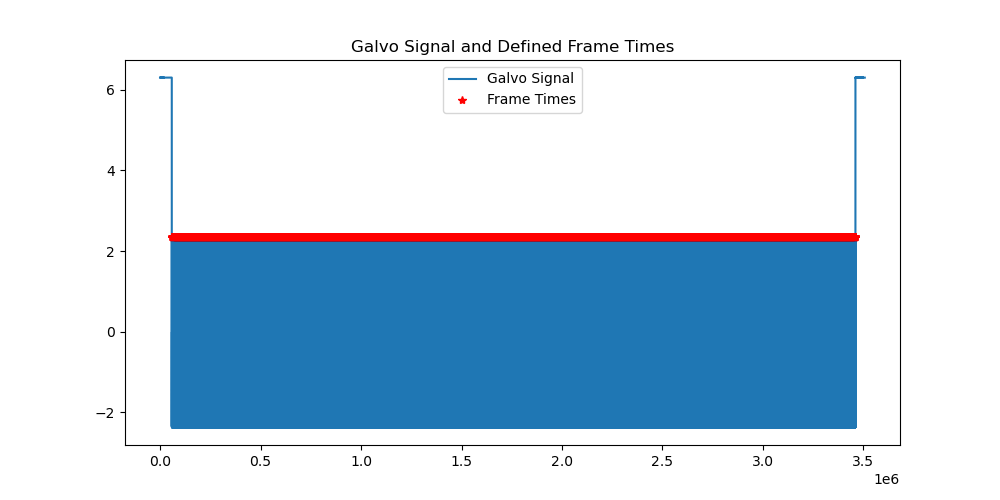

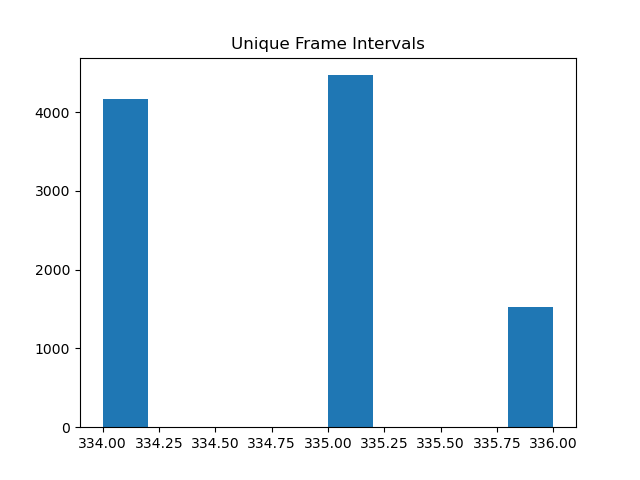

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-884, Sync File: 2024_10_01_0001.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


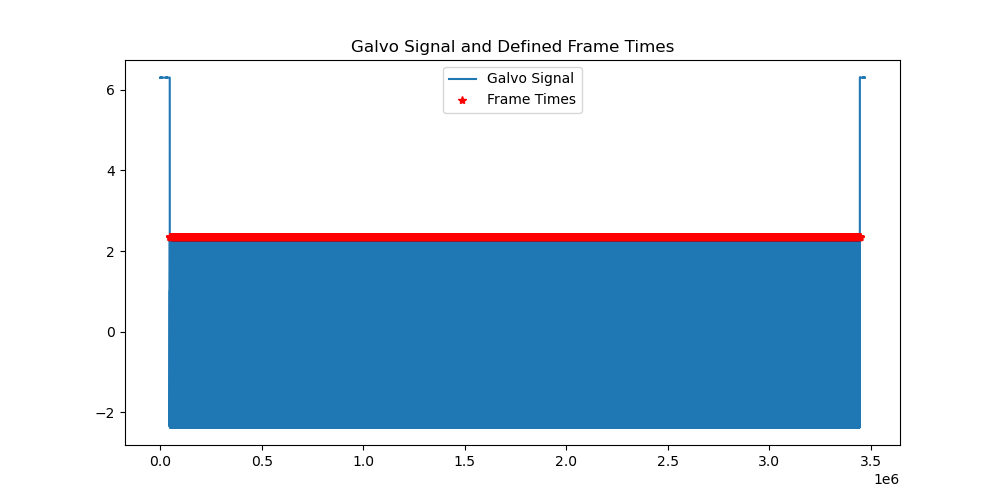

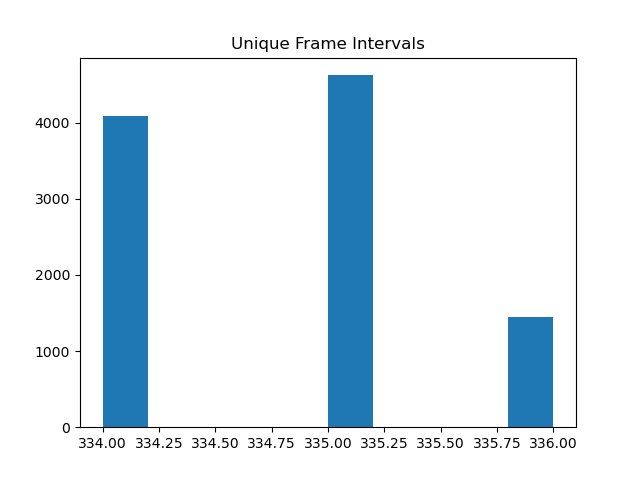

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-885, Sync File: 2024_10_01_0002.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


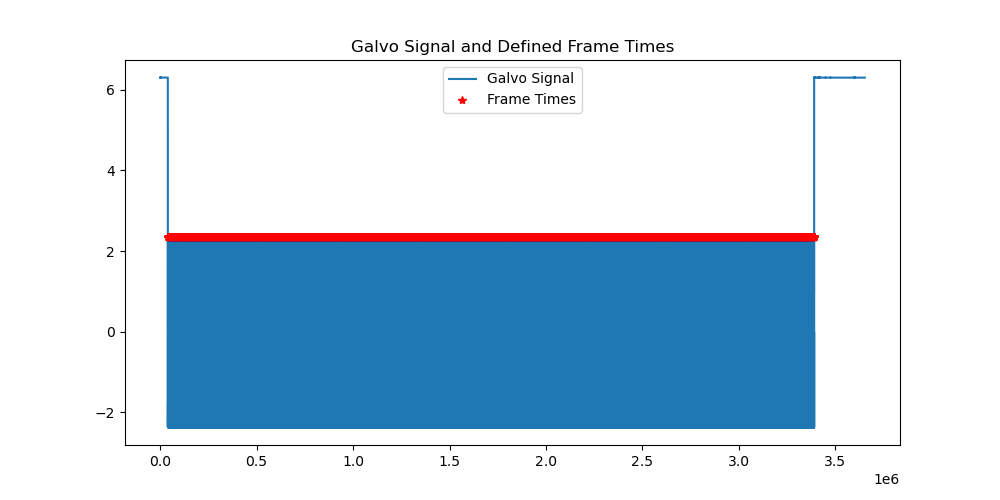

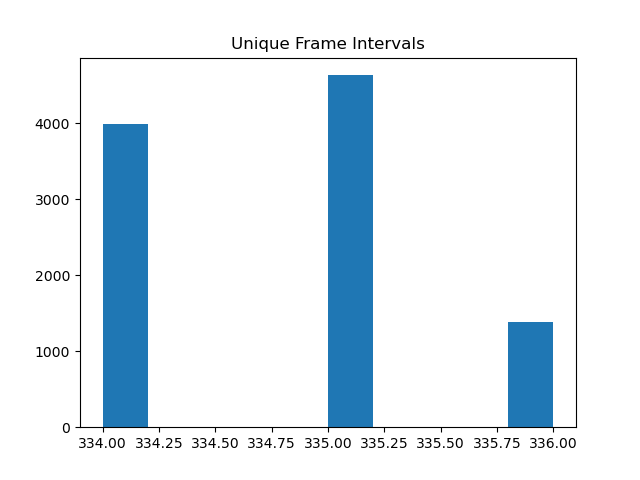

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-886, Sync File: 2024_10_01_0003.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


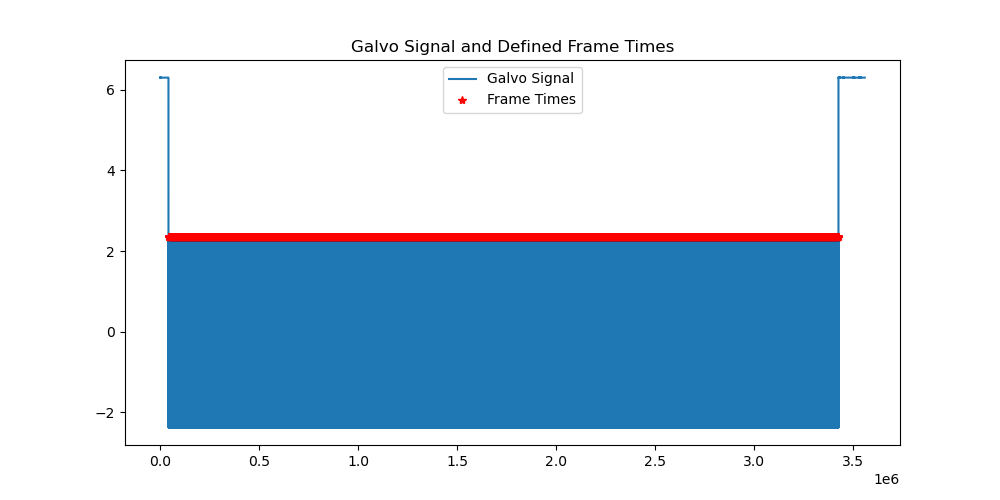

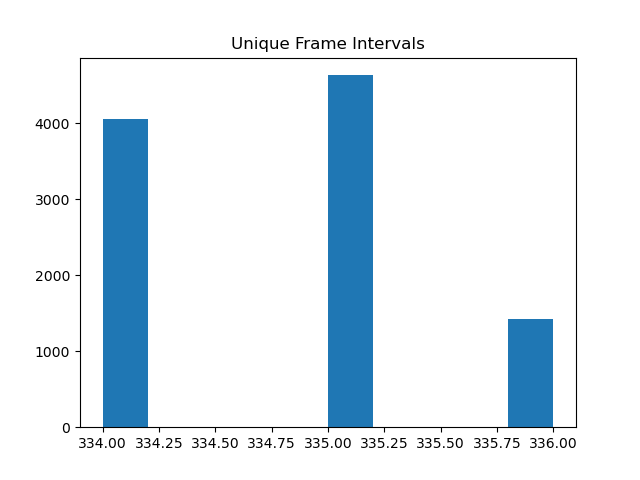

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-887, Sync File: 2024_10_01_0004.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


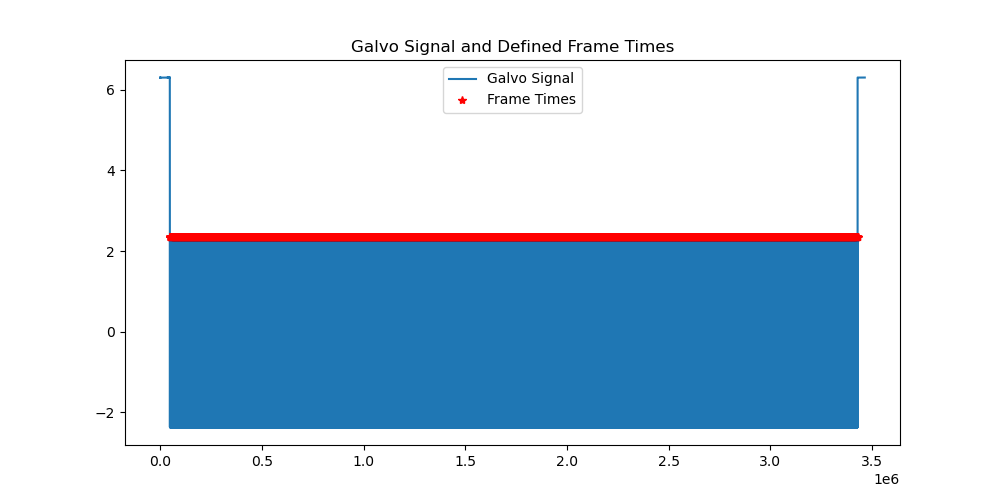

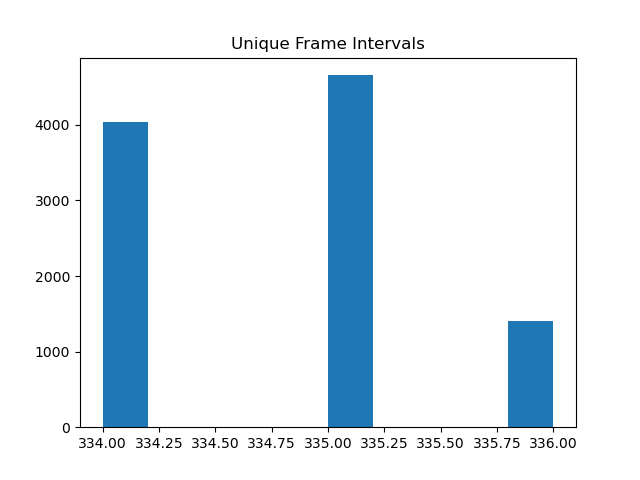

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-888, Sync File: 2024_10_01_0005.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


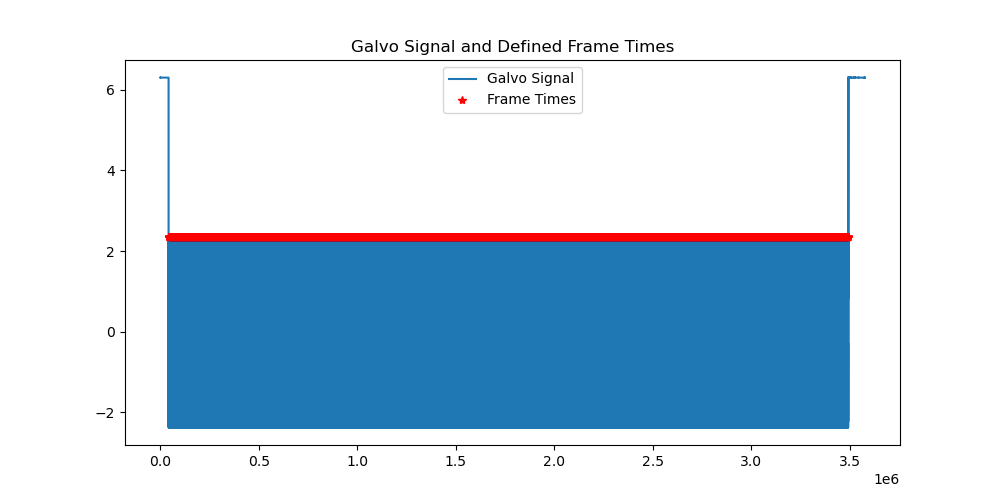

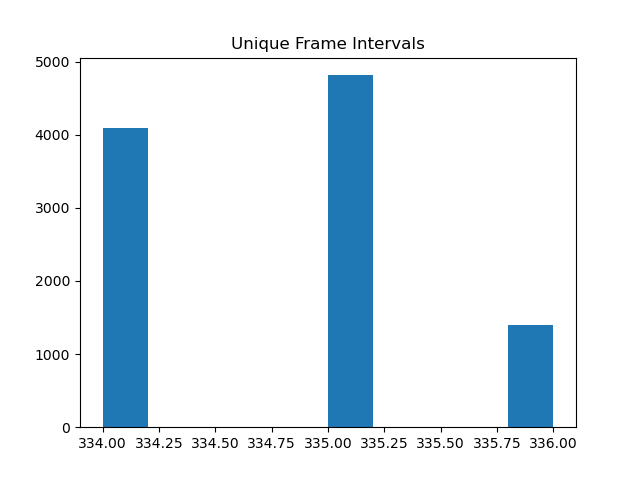

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-889, Sync File: 2024_10_01_0006.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


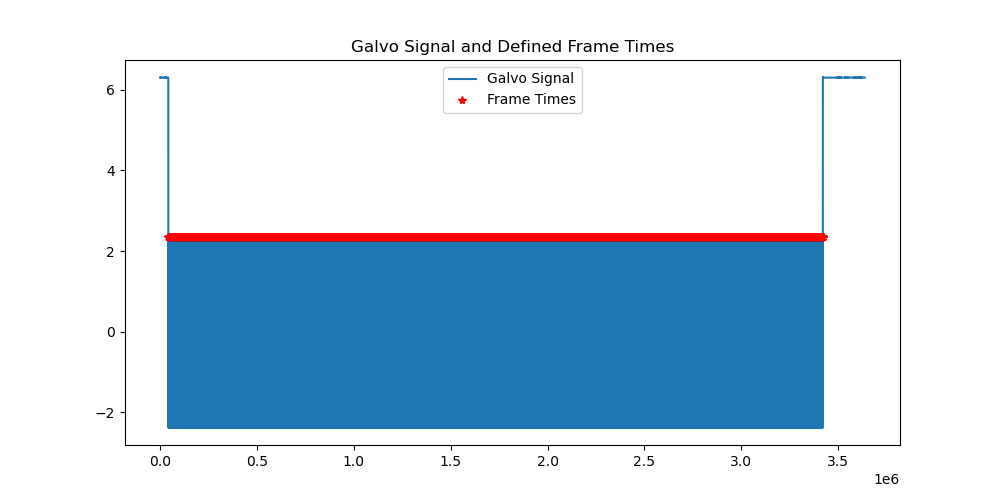

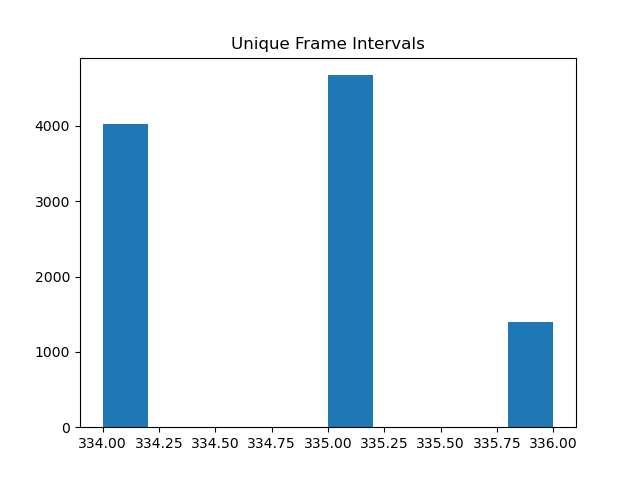

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-890, Sync File: 2024_10_01_0007.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


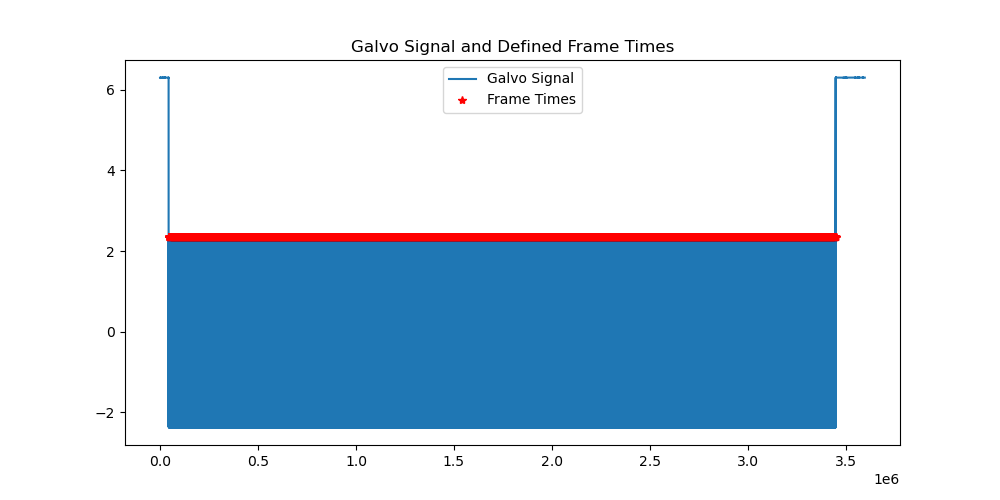

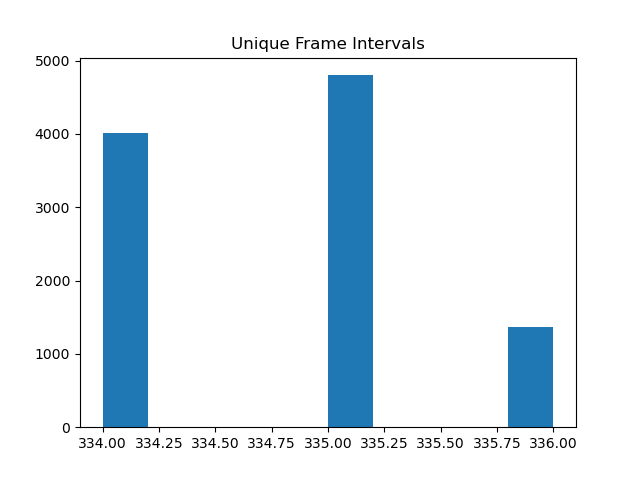

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-891, Sync File: 2024_10_01_0008.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


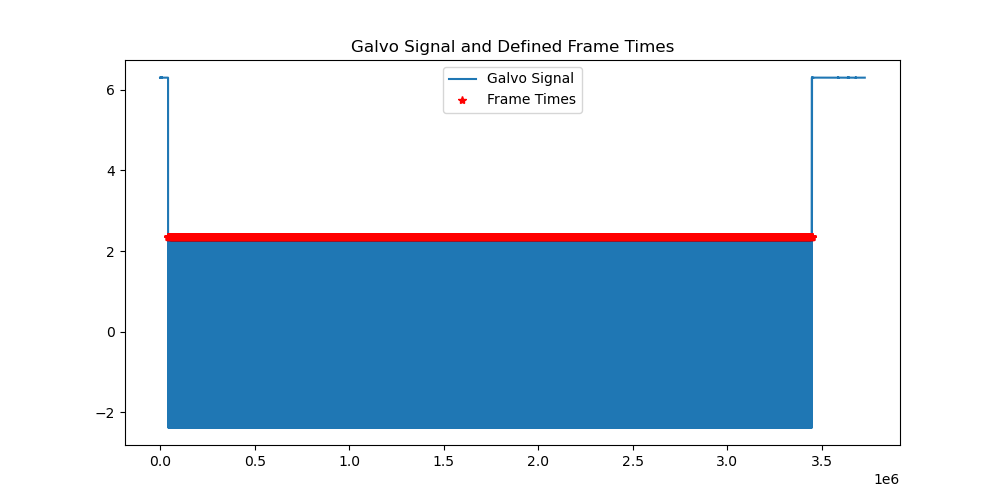

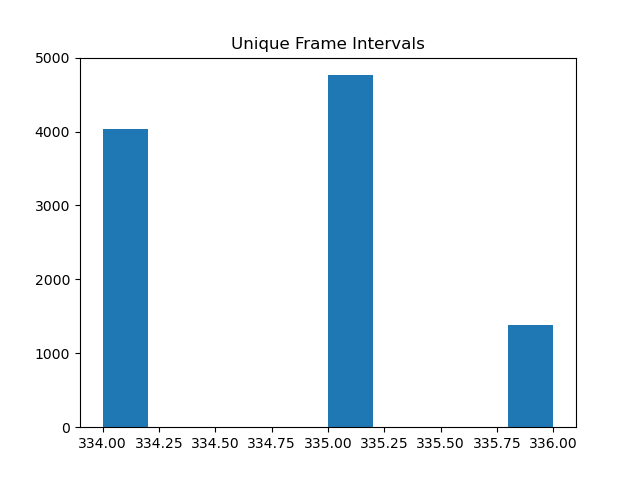

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-892, Sync File: 2024_10_01_0009.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


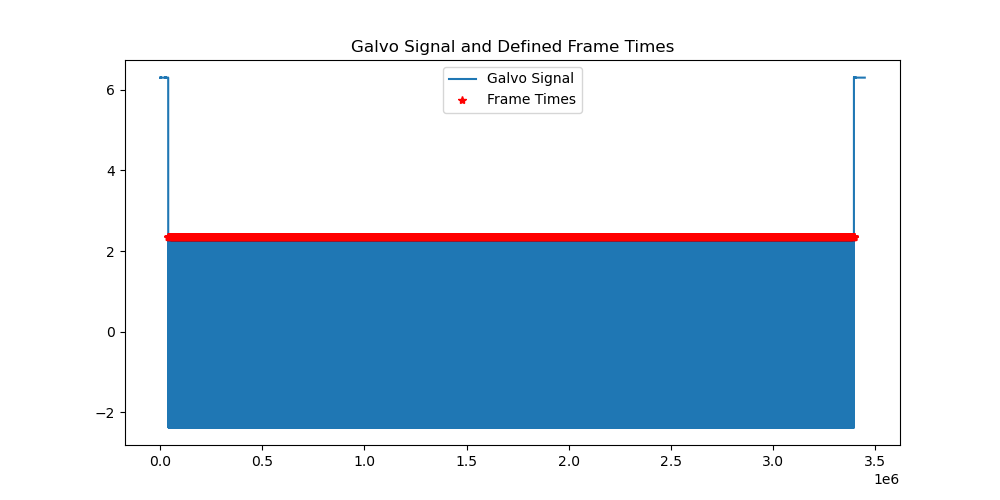

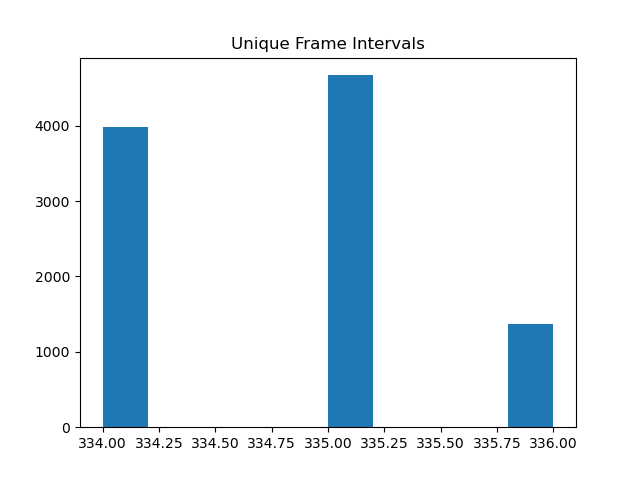

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-893, Sync File: 2024_10_01_0010.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead
c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_neural_data.py:406: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


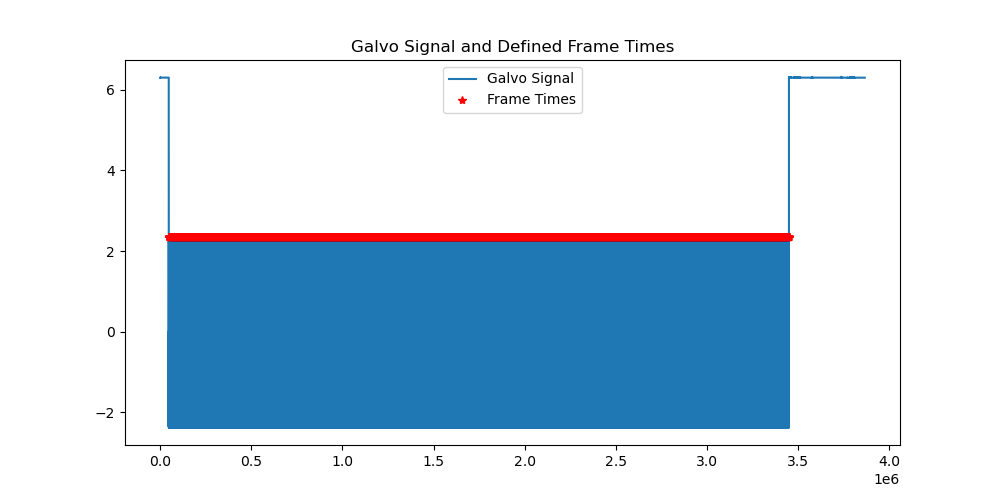

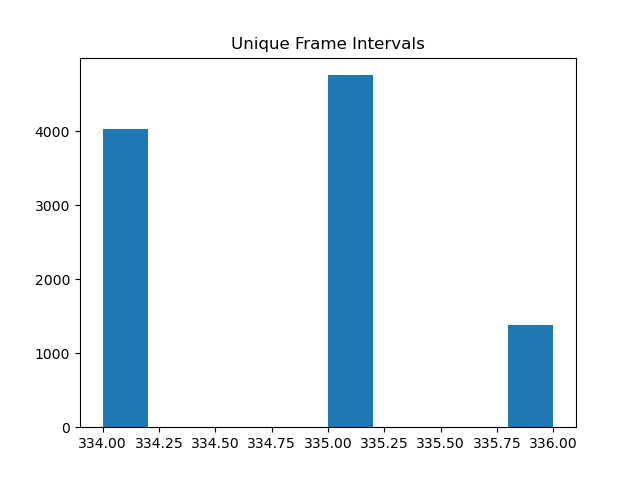

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-894, Sync File: 2024_10_01_0011.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


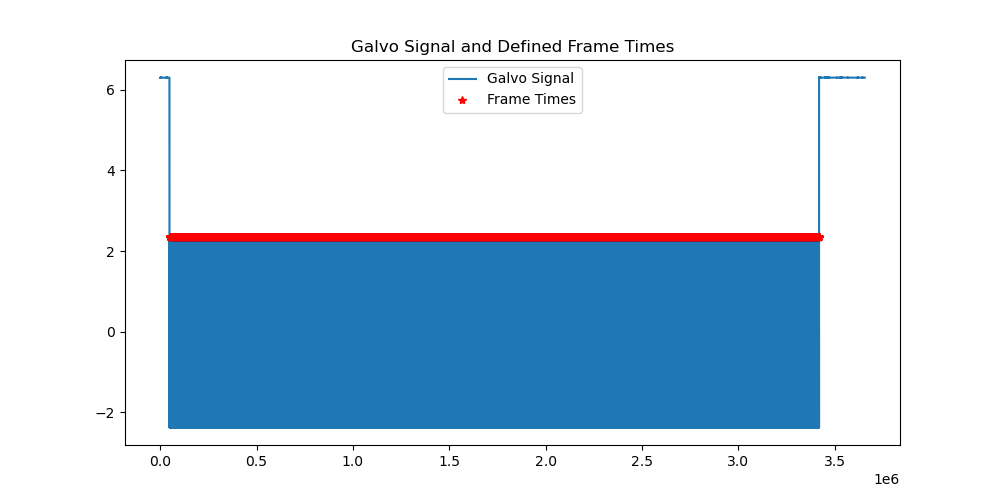

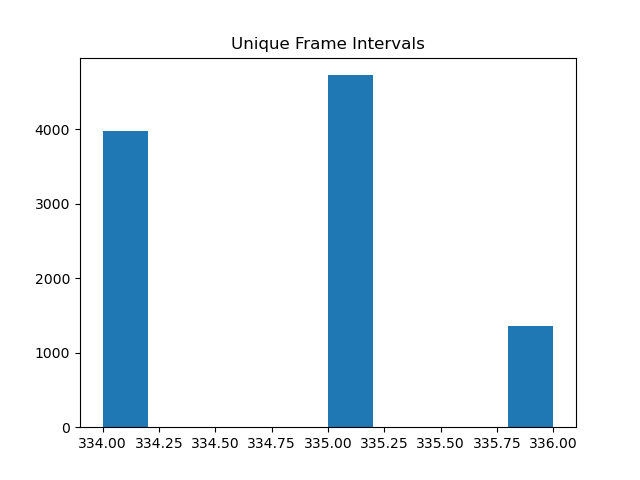

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-895, Sync File: 2024_10_01_0012.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


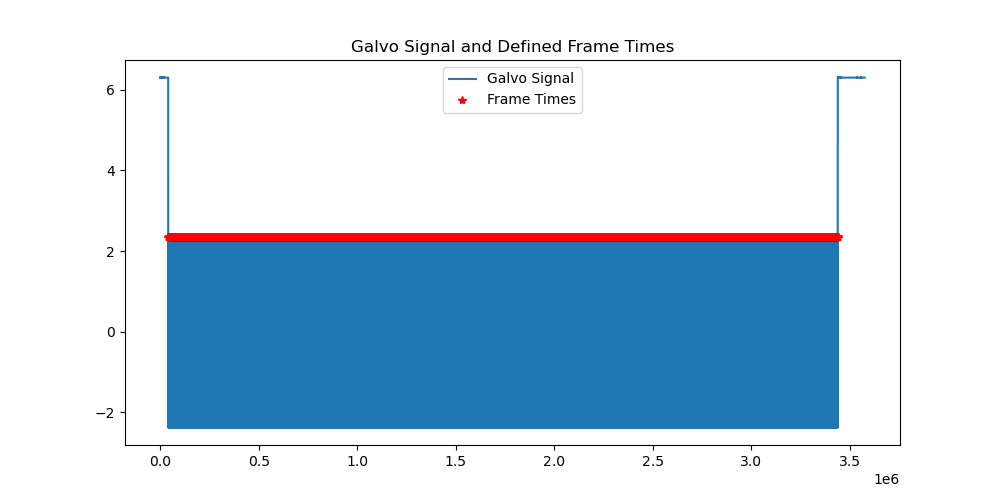

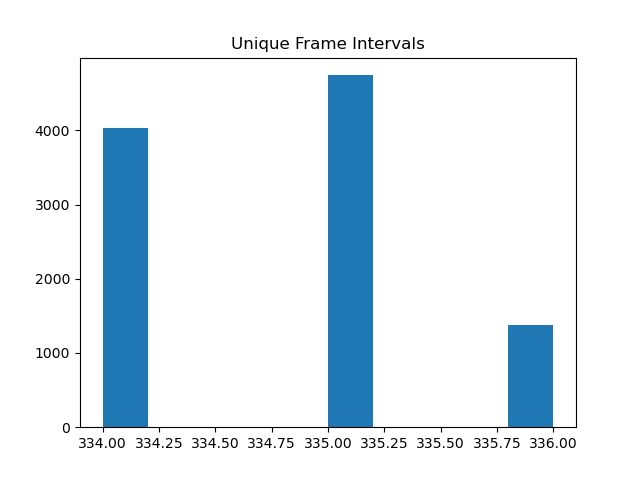

Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-896, Sync File: 2024_10_01_0013.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


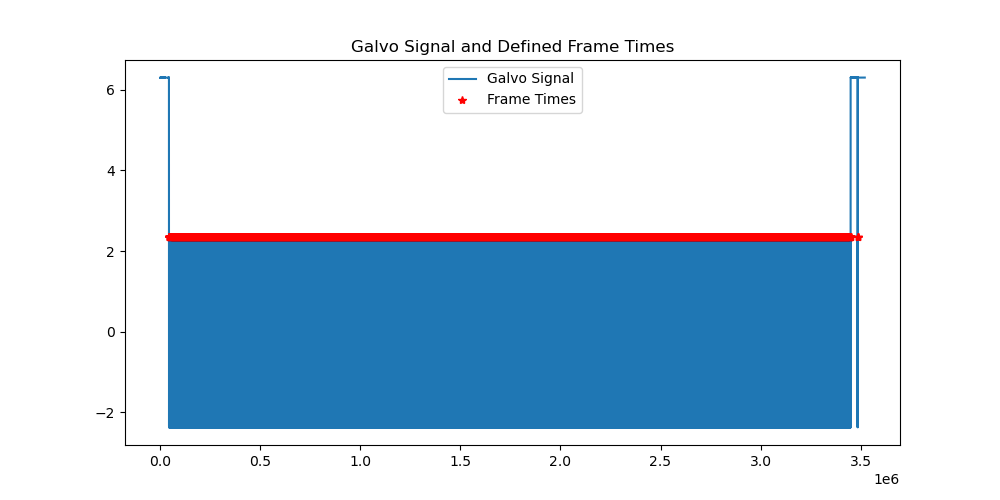

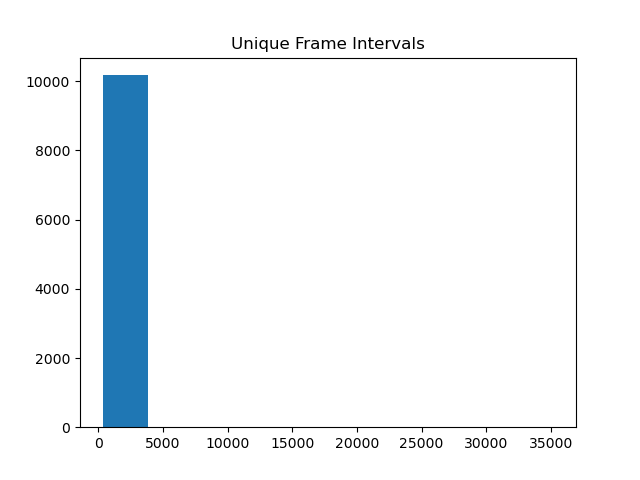

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


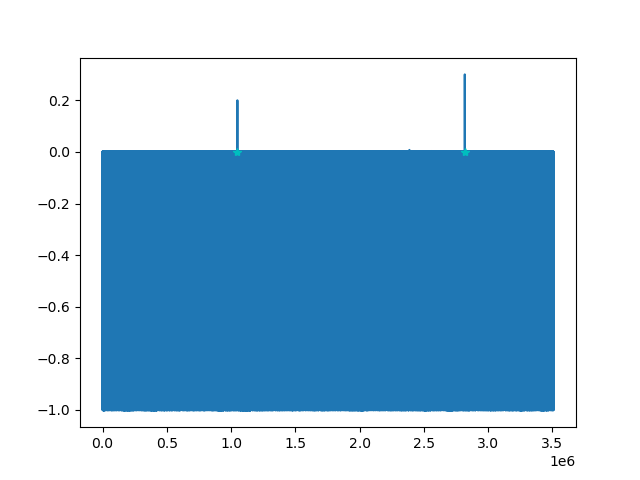

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


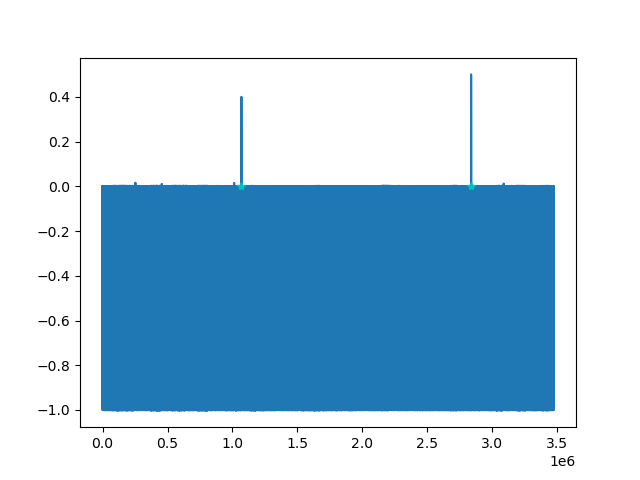

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


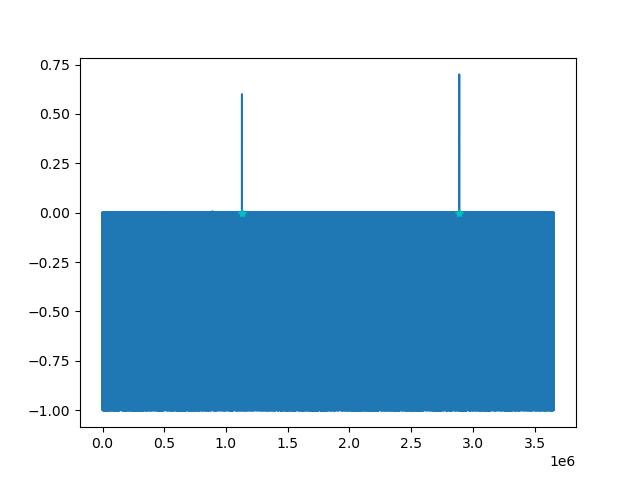

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


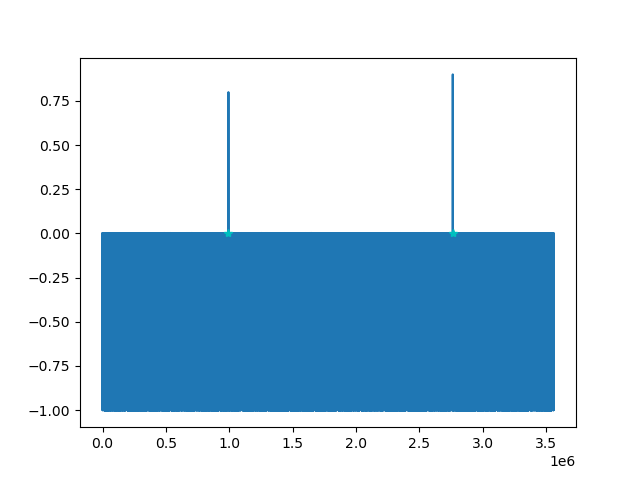

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


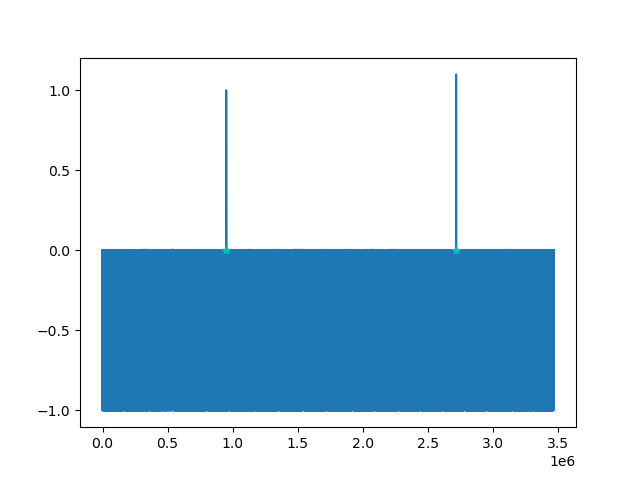

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


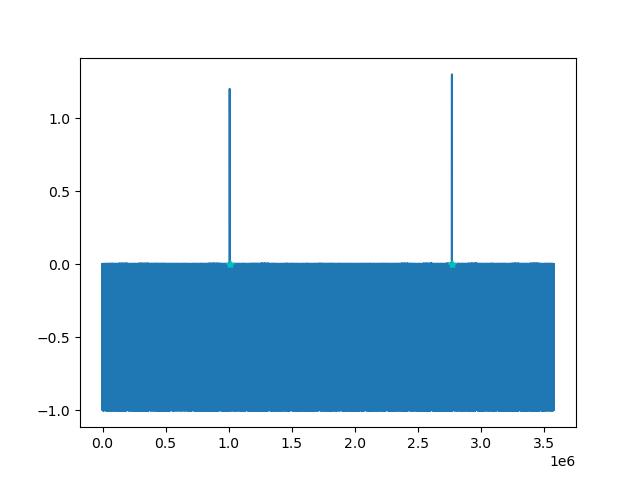

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


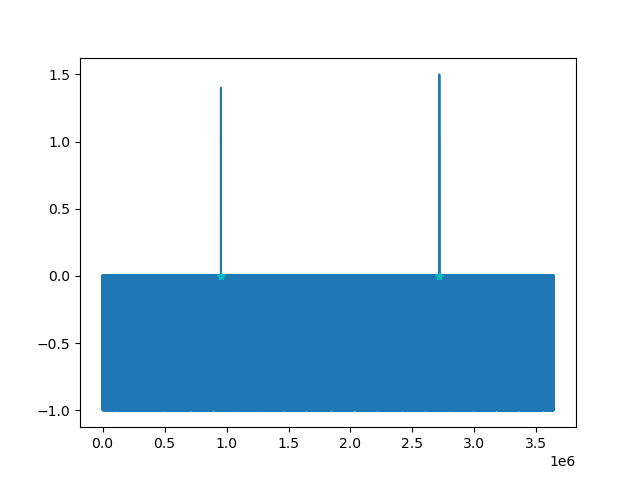

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


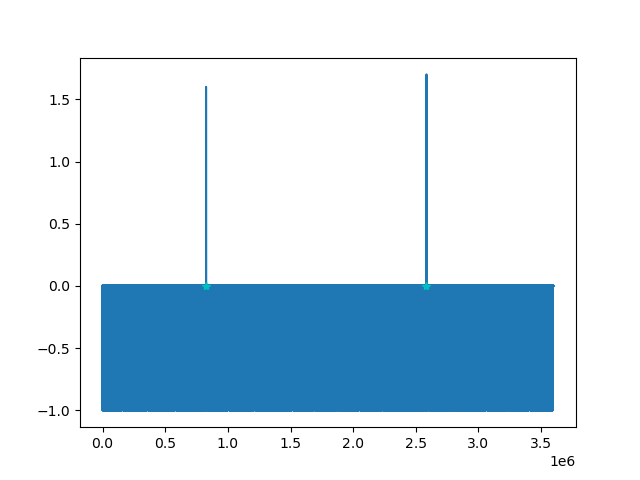

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


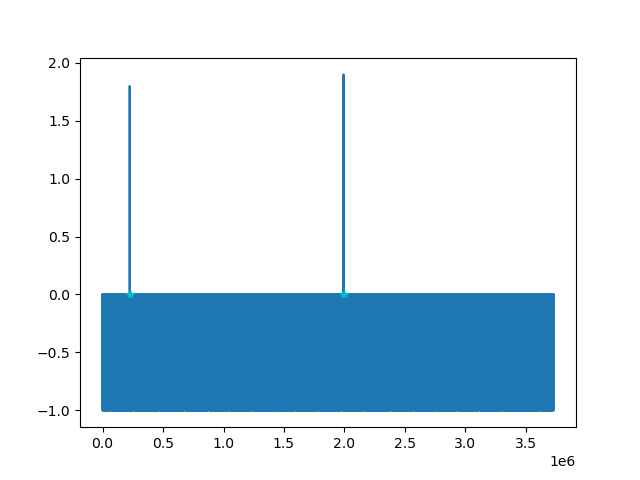

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


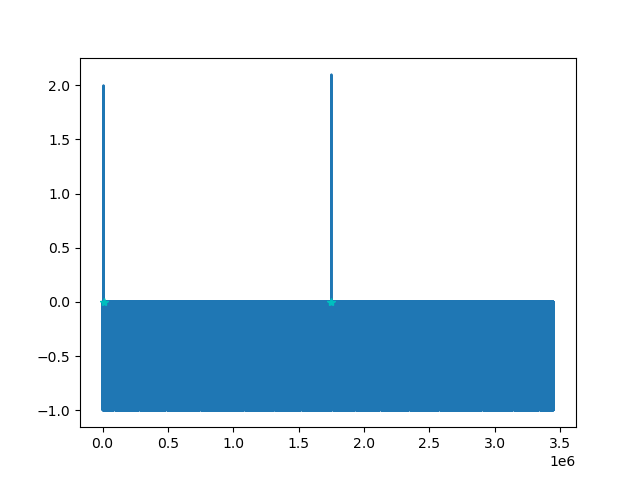

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


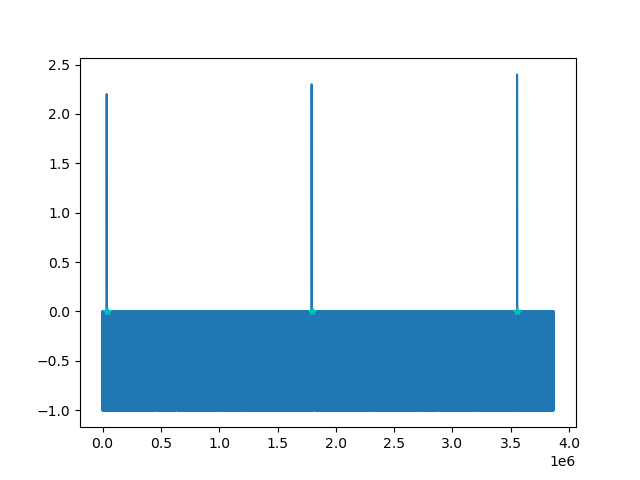

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


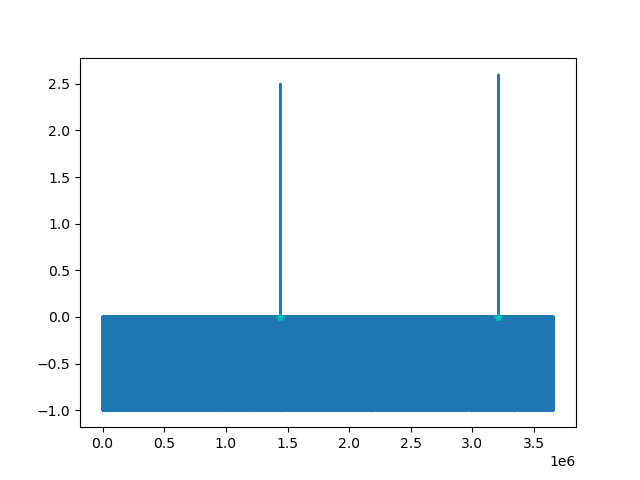

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


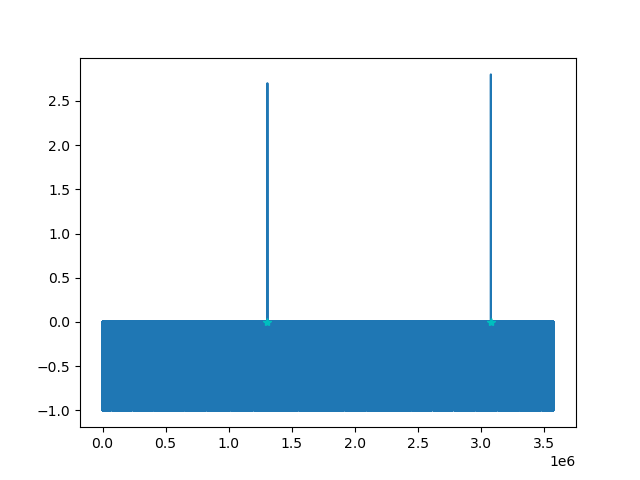

Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


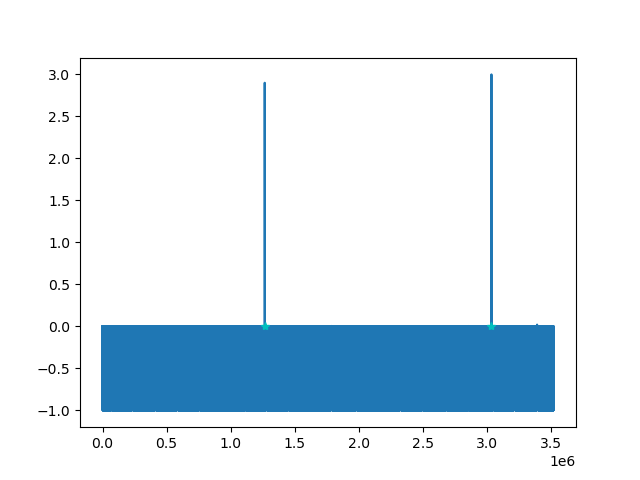

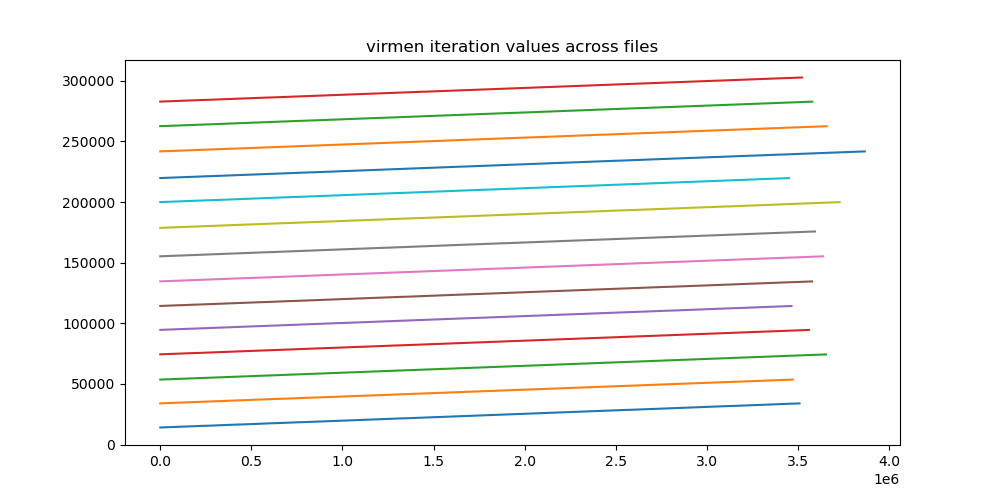

In [8]:
## AUTOMATIC VERSION, IF ISSUES CHECK PATHS
# These paths should also be constant 
conditions_path = os.path.join(runyan5, "Connie/condition_per_speaker.mat")
conditions_per_speaker = scipy.io.loadmat(conditions_path)['conditions_per_speaker']
sound_info["condition_per_speaker"] = conditions_per_speaker

# Load virmen data and align imaging date to virmen iterations
# Load reward info from Runyan4 server, runyan4 & runyan5 defined in imports section
mdl_pure_sol_path = os.path.join(runyan4, "Connie/extra_tests/2023-12-11/mdl_pure_sol.mat")
mdl_end_trial_sol_path = os.path.join(runyan4, "Connie/extra_tests/2023-12-11/mdl_end_trial_sol.mat")

mdl_pure_sol = scipy.io.loadmat(mdl_pure_sol_path)
mdl_end_trial_sol = scipy.io.loadmat(mdl_end_trial_sol_path)

# Load dff and deconvolution data

act = os.path.join(info['save_path'],'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)
deconv = activity['deconv']
dff = activity['dff']

dataCell, data = align.load_virmen_data(info)
alignment_info = align.get_frame_times(info["imaging_base_path"], info["sync_base_path"], info["galvo_channel"], plot_on=1)


string = info["vr_sync_string"] # NOT NEEDED FOR OUR DATA 
digidata_its = align.get_digidata_iterations( info["sync_base_path"], string, info['virmen_channel'])

virmen_it, trial_its, sound_condition_array = align.get_virmen_iterations_and_times_digidata_positive_peaks(
    base=info["sync_base_path"],
    virmen_channel_number=info["virmen_channel"],
    string=info["vr_sync_string"],
    sound_condition_array=[],
    data=data,
    file_trial_ids=[],
    file_estimated_trial_info=[]  # Added this parameter
)

## package frame times to feed into find frame times function in the find spirals code
frame_times_list =[]
for acquisition in alignment_info:
    frame_times_list.append(acquisition['frame_times'])

imaging = align.align_virmen_data(dff, deconv, virmen_it, alignment_info, data, dataCell, trial_its, stimulus_info=None, reward_info=None)

#### **2.3 -** Save imaging trial structure to .mat and .pkl

In [9]:
# SAVE THE DATA TO .mat and .pkl
save_path = info['save_path']
imaging_sorted = {}
prefix = 'Trial_'

# Add zero buffers to trial numbers of 1,2 digits (helps with matlab sorting)
for k in imaging:
    dict_key = f"{prefix}{int(k.split('_')[1]):03}"
    imaging_sorted[dict_key] = imaging[k]

# Organize and save imaging structure
imaging_sorted = {
    'imaging_sorted' : imaging_sorted
}

hdf5storage.savemat(os.path.join(save_path,'imaging_py.mat'),imaging_sorted, format='7.3', oned_as='column')

save_imaging_data(imaging, save_path)

## **Section 3: Process Spirals for single cell & SLM stimulation** 


#### **3.1 -** Set up data structures & load suite2p data

In [6]:
# Should be automatic if previous path input was correct
from process_spirals import GalvoTargetAnalysis

align_spirals = GalvoTargetAnalysis()
align_spirals.get_directories(
    raw_data_path = os.path.join(full_server, experimenter, 'Rawdata', mouseID, date, 'TSeries'),
    suite2p_path = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date, 'suite2p','plane0'),
    sync_path = os.path.join(full_server,experimenter,sync_type, mouseID,date),
    save_path = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date, 'python_proc'),
    base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)
)

base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)
align_spirals.get_activity(base)

# Set number of imaging channels
align_spirals.nchannels = 2  # Adjust if different

# Load Suite2p data 
align_spirals.load_suite2p_data()

#### **3.2 -** Get Frame Timing Information

In [9]:
# IF YOU WANT TO RECALCULATE FRAME TIMES SET frame_times_list = NONE
alignment_info =  align_spirals.get_frame_times(channel_number=2,frame_times_list=None)

for idx, acq in enumerate(alignment_info):
    align_spirals.plot_frame_times(num=idx, galvo_signal=acq['galvo_signal_norm'],  frame_times=acq['frame_times'],plot_on=False)


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-883, Sync File: 2024_10_01_0000.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-884, Sync File: 2024_10_01_0001.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-885, Sync File: 2024_10_01_0002.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-886, Sync File: 2024_10_01_0003.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-887, Sync File: 2024_10_01_0004.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-888, Sync File: 2024_10_01_0005.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-889, Sync File: 2024_10_01_0006.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-890, Sync File: 2024_10_01_0007.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-891, Sync File: 2024_10_01_0008.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-892, Sync File: 2024_10_01_0009.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-893, Sync File: 2024_10_01_0010.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-894, Sync File: 2024_10_01_0011.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-895, Sync File: 2024_10_01_0012.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


Imaging Dir: TSeries-09262024-920nm-1.75x-275poc-896, Sync File: 2024_10_01_0013.abf


Units "v" can not be converted to a quantity. Using dimensionless instead
Units "v" can not be converted to a quantity. Using dimensionless instead


*Plot frames for specific acquisitions in interactive plots*

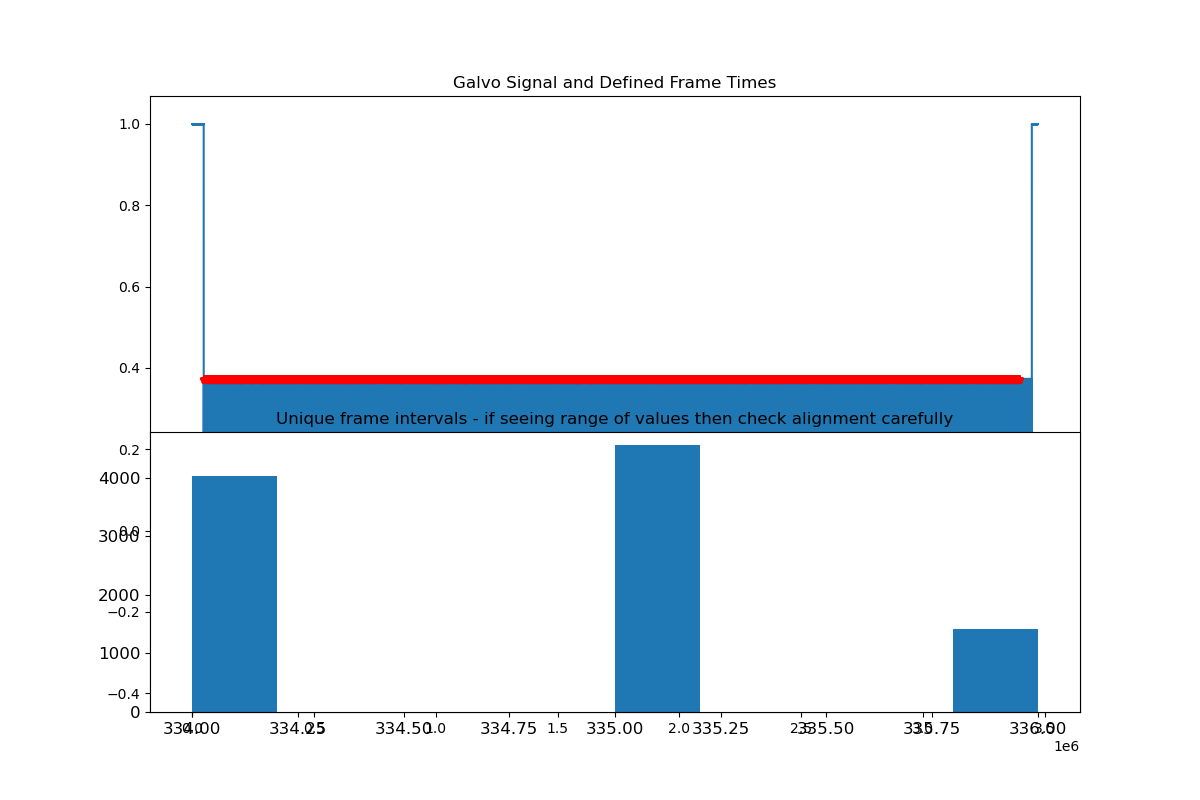

In [13]:
# Plot specific acquisitons in interactive plots to check the frame timings
idx = 1
acq = align_spirals.alignment_info[idx]
align_spirals.plot_frame_times(num=idx, galvo_signal=acq['galvo_signal_norm'],  frame_times=acq['frame_times'],plot_on=True)

#### **3.3 -** Get Spiral Locations and Timing

In [10]:
acquisition_data = align_spirals.get_spiral_locations(min_height=0.1)

for acq_data in acquisition_data:
    align_spirals.plot_spiral_detection(acq_data, save_dir=align_spirals.save_folder, show_plot=False)


Parsing TSeries-09262024-920nm-1.75x-275poc-883.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09262024-920nm-1.75x-275poc-883_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'IterationDelayAttribute', 'CalcFunctMapAttribute', 'PVMarkPointElement']

Parsing TSeries-09262024-920nm-1.75x-275poc-884.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09262024-920nm-1.75x-275poc-884_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'IterationDelayAttribute', 'CalcFunctMapAttribute', 'PVMarkPointElement']

Parsing TSeries-09262024-920nm-1.75x-275poc-885.xml
Top level keys: ['versionAttribute', 'dateAttribute', 'notesAttribute', 'SystemIDs', 'PVStateShard', 'Sequence']

Parsing TSeries-09262024-920nm-1.75x-275poc-885_Cycle00001_MarkPoints.xml
Top level keys: ['IterationsAttribute', 'Iteratio

c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_spirals.py:898: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\RUNYAN1\OneDrive - University of Pittsburgh\Documents\GitHub\Runyan_lab_data_alignment_python\process_spirals.py:903: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(spiral_plot_dir, filename))


*Plot spiral locations for specific acquisitions in interactive plots*

c:\Users\RUNYAN1\AppData\Local\anaconda3\envs\neural_analysis\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


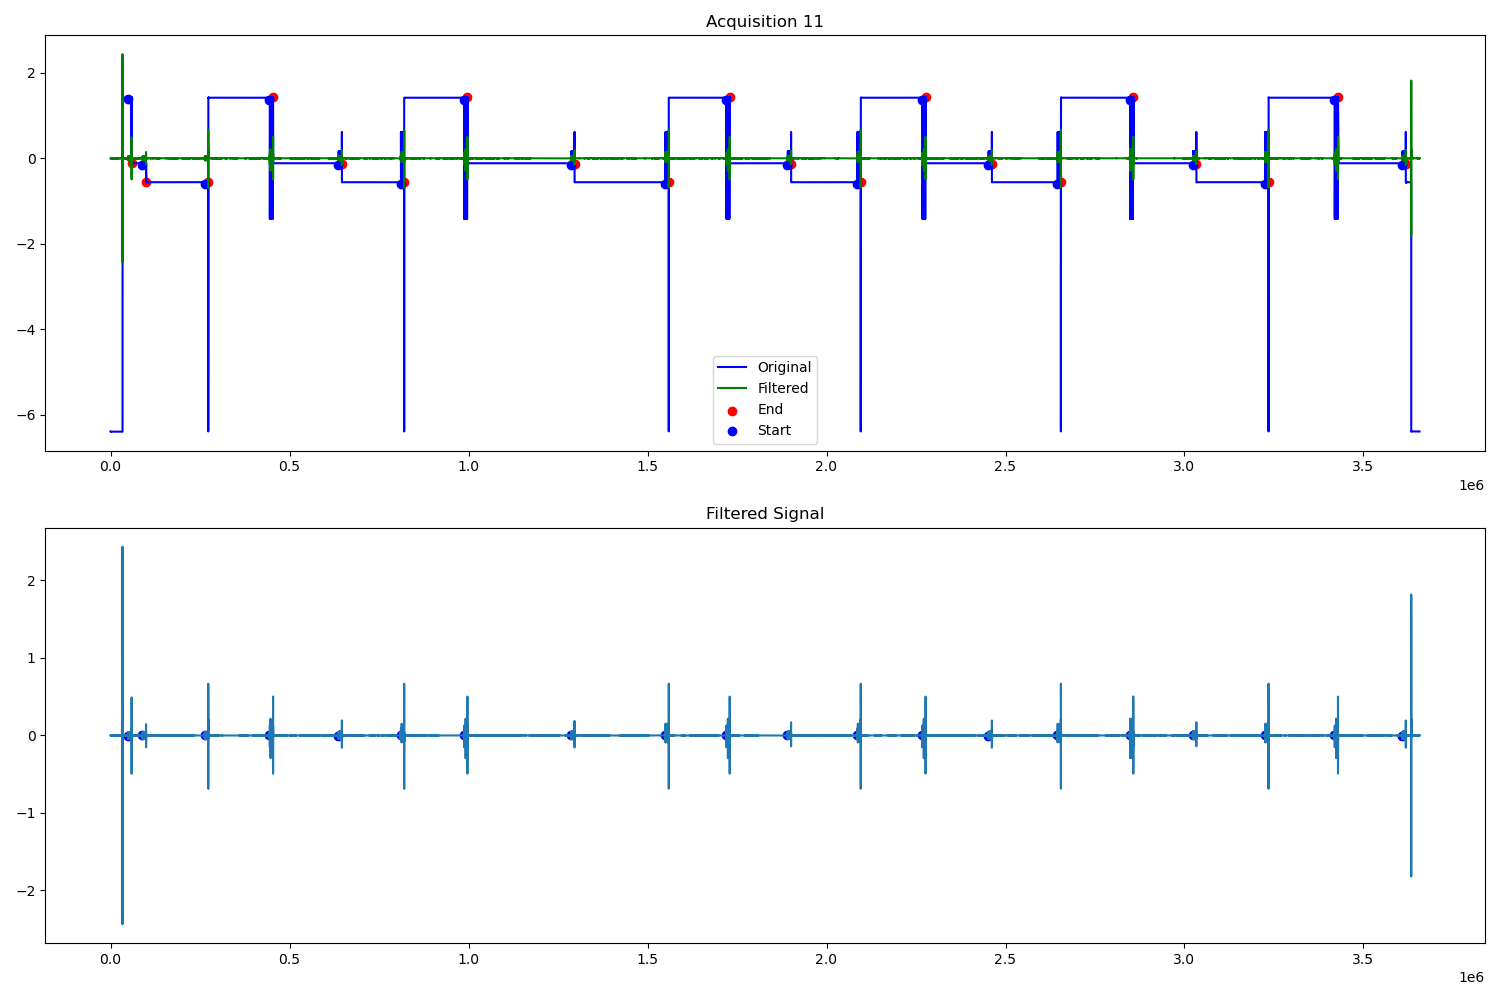

In [15]:
# Look at individual acquisitions to inspect the accuracy of the spiral detections
align_spirals.plot_spiral_detection(acquisition_data[11])

#### **3.4 -** Make Trial Structure to review target response to photostimulation

In [11]:
# Set trial window parameters
pre_trial_window = 100
post_trial_window = 150

# Process targets and trials
align_spirals.process_targets_and_trials(
    pre_trial_window=pre_trial_window,
    post_trial_window=post_trial_window
)

#### **3.5 -** Create ROI Activity Plots of Potential Targets

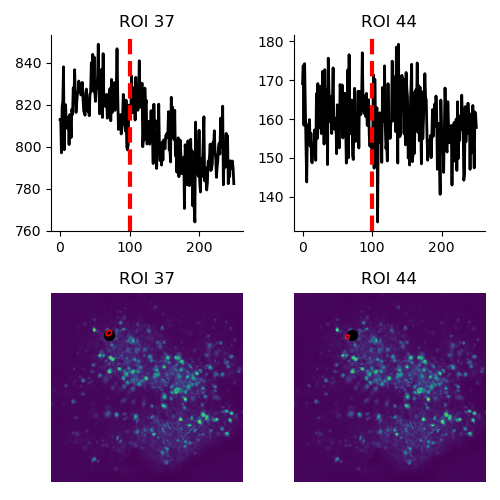

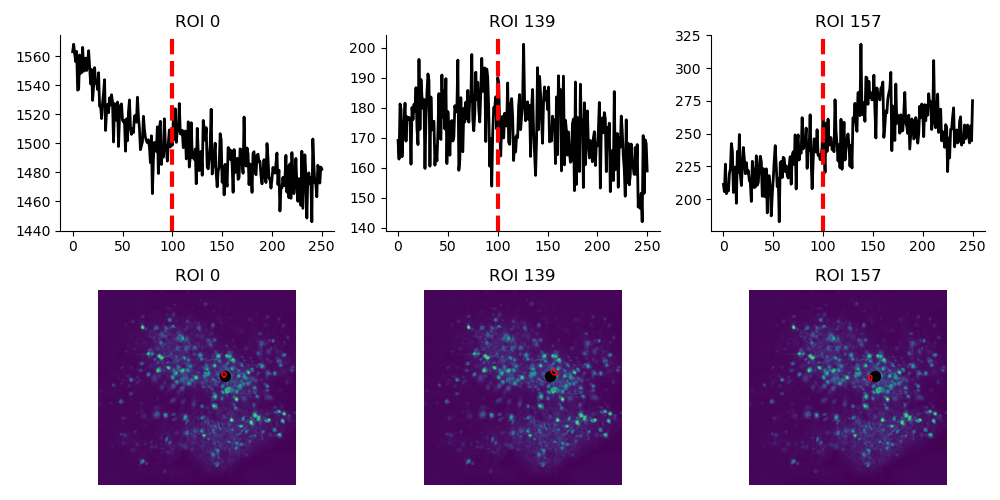

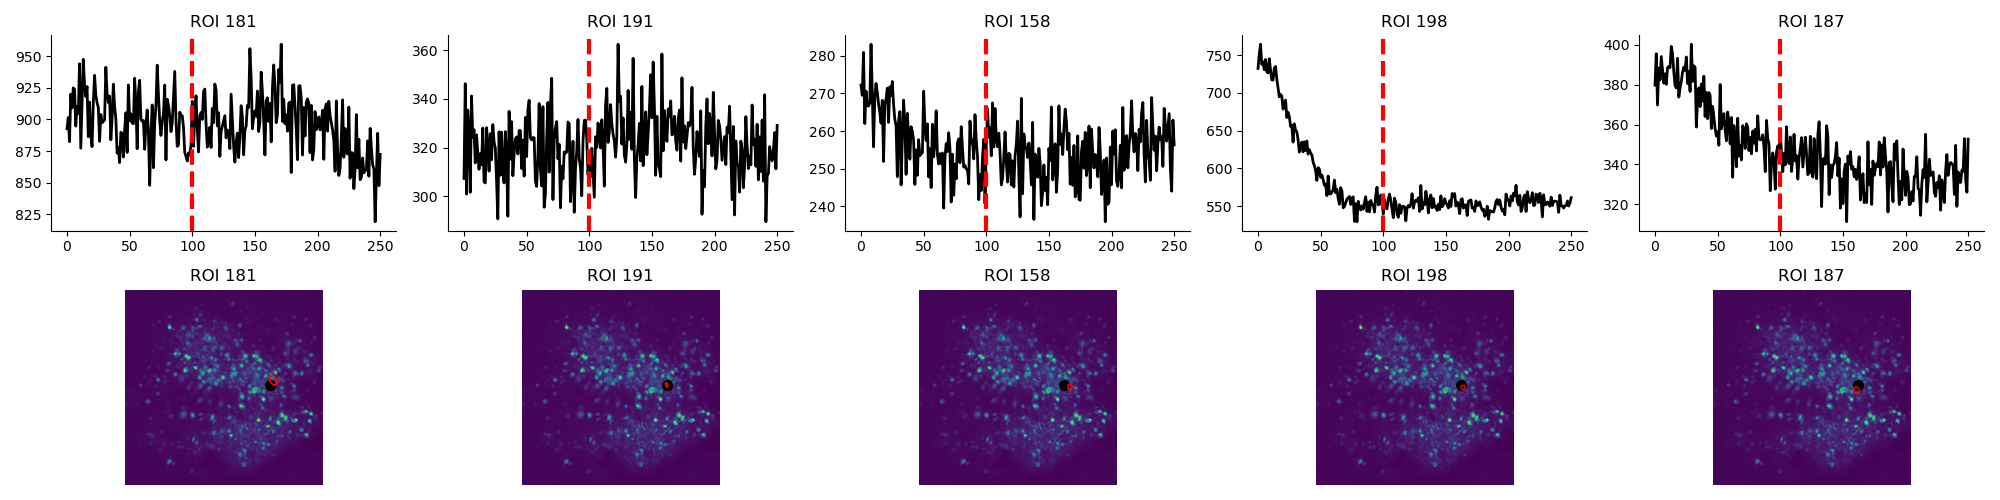

In [12]:
# Runs Automatically, use these plots to choose target ROIS
F_struct, roi_inds =  align_spirals.create_ROI_traces()

align_spirals.plot_ROI_traces(F_struct=F_struct,pre_trial_window=pre_trial_window) 

*Choose ROIs for each target based on above plots*

In [13]:
## PICK WHICH ROI FITS THE TARGET
target_cells = np.ndarray(shape=[0,len(align_spirals.alignment_info[0]['points'])],dtype=int)
for targ in range(len(align_spirals.alignment_info[0]['points'])):
    ind = input('Input target cell ID for Target ' + str(targ+1))
    target_cells = np.append(target_cells,int(ind))
    
for targ in range(len(align_spirals.alignment_info[0]['points'])):
    print('Target ' + str(targ+1) + ' = ROI: ' + str(target_cells[targ]))


Target 1 = ROI: 37
Target 2 = ROI: 0
Target 3 = ROI: 191


#### **3.6 -** Save Spiral Alignment Info

In [14]:
# Save data for MATLAB
import scipy.io as sio

# save the suite2p and dff inds for each cell
act = os.path.join(align_spirals.base,'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)
celi = activity['celi']

align_spirals.find_s2p_and_dff_indices(celi,target_cells)

# Create dictionary with all the relevant data
matlab_data = {
    'roi_inds': roi_inds,
    'trial_info': align_spirals.trial_info,
    'alignment_info': align_spirals.alignment_info,
}

# Save to .mat file
save_path = os.path.join(align_spirals.base, 'spirals_data.mat')
sio.savemat(save_path, matlab_data)

print(f"Data saved to: {save_path}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## **Section 4: Calculate Influence**

#### **4.1 -** Load class and relavent data

In [55]:
import importlib
code_directory = f'C:\\Users\\RUNYAN1\\OneDrive - University of Pittsburgh\\Documents\\GitHub\\Runyan_lab_data_alignment_python'
os.chdir(code_directory)
import pickle
import calculate_influence
from calculate_influence import CalculateInfluence
importlib.reload(calculate_influence)
inf = CalculateInfluence()

base = os.path.join(full_server, experimenter, 'ProcessedData', mouseID, date)

act = os.path.join(base,'spikes', 'processed_activity_py.pkl')
with open (act, "rb") as file: 
    activity = pickle.load(file)

t = os.path.join(base, 'trial_and_target_info.npz')
trial_info = np.load(t,allow_pickle=True)

deconv = activity['deconv']
dff = activity['dff']

offset_data = np.load(os.path.join(base,'offsetInfo.npz'),allow_pickle=True) 

spirals_data = scipy.io.loadmat(os.path.join(base,'spirals_data.mat'))
microns_per_pixel = spirals_data['alignment_info'][0][13][0,0]['microns_per_pixel'][0][0]
del spirals_data

#### **4.2 -** Finalized trial frames, calculate influence & calculate distance between cells

In [86]:
# Remove stimulation trials with heavy motion 
trial_frames = trial_info['trial_frames']

trial_frames_final = inf.calculate_max_motion(dff,trial_frames,offset_data['distoff_um'])

# Calculate influence with updated trial structure
stim_id = trial_info['stim_id']
full_trials = trial_info['full_trials']

# Suite2p Data 
stat_file = os.path.join(base,'suite2p','plane0', 'stat.npy')       
stat = np.load(stat_file, allow_pickle=True)
iscell = np.load(os.path.join(base,'suite2p','plane0', 'iscell.npy'))

# Load indices for dff and s2p
with open(f'{base}\indices.pkl', 'rb') as file:
        indices = pickle.load(file)
active_inds = indices['dff_inds']['target_cell_dff']

non_inds = indices['dff_inds']['non_cell_dff']
red_inds = indices['dff_inds']['red_cell_dff']

cell_type_names = ['non', 'som'] # correspond to activity struct ordering

activity_struct = [dff[non_inds, :] , dff[red_inds]]
pre_trial_window = 100
post_trial_window = 150
influence_dff,structs = inf.inf_calculation(trial_frames_final, stim_id, activity_struct, pre_trial_window, post_trial_window, full_trials)


activity_struct = [deconv[non_inds, :] , deconv[red_inds]]
influence_deconv,structs = inf.inf_calculation(trial_frames_final, stim_id, activity_struct, pre_trial_window, post_trial_window, full_trials)

# Use those indices to populate cell locs structure
# cell_locs has the med pixels of each cell, cell_type is the cell_type at each index corresponding to cell_locs
# 0 = PYR, 1 = red

cell_locs, cell_type = inf.create_cell_locs_struct(base,stat,iscell)

# Calculate the distances between each cell groups (targets,PYR, red)
dist, dist_from_target, dist_from_target_red = inf.calculate_distances(active_inds, cell_locs, cell_type, trial_info['points'], microns_per_pixel, base)


#### **4.3 -** Save influence, distance, and updated imaging_py structure

In [ ]:
def save_structures_local(base, distances,inf_data,activity):
    import hdf5storage

    name = os.path.join(base,'distances.pkl')
    with open(name,"wb") as file:
        pickle.dump(distances,file,)
    
    name = os.path.join(base,'distances.mat')
    hdf5storage.savemat(name,distances, format='7.3', oned_as='column',truncate_existing=True)

    name = os.path.join(base,'inf_data.pkl')
    with open(name,"wb") as file:
        pickle.dump(inf_data,file)

    name = os.path.join(base,'inf_data.mat')
    hdf5storage.savemat(name,inf_data, format='7.3', oned_as='column',truncate_existing=True)

    name = os.path.join(base,'activity.pkl')
    with open(name,"wb") as file:
        pickle.dump(activity,file)
    
    name = os.path.join(base,'activity.mat')
    hdf5storage.savemat(name,activity, format='7.3', oned_as='column',truncate_existing=True)



In [ ]:
# package inf data into a save structure
distances = {
    'dist' : dist,
    'dist_from_target' : dist_from_target,
    'dist_from_target_red' : dist_from_target_red
}

influence_dff_str = {str(cell_type_names[key]) : value for key, value in influence_dff.items()}
influence_deconv_str = {str(cell_type_names[key]) : value for key, value in influence_dff.items()}
structs_str = {str(cell_type_names[key[0]])+ ' target: '+str(key[1]) : value for key, value in structs.items()}

influence = {
    'influence_dff' : influence_dff_str,
    'influence_deconv' :  influence_deconv_str
}

inf_data = { 
    "Influence" : influence,
    "dist_from_target" : dist_from_target,
    "noise_correlations" : np.NaN,
    "trial_activity" : structs_str,
    "significant_inf" : np.NaN,
    "trial_frames_final" : trial_frames_final,
    "distance" : distances
}

non_inds = indices['dff_inds']['non_cell_dff']
red_inds = indices['dff_inds']['red_cell_dff']

activity = {
    "dff_non" : dff[non_inds, :],
    "dff_red" : dff[red_inds,:],
    "deconv_non" : deconv[non_inds,:],
    "deconv_red" : deconv[red_inds]
}

#inf.save_structures(align_spirals.base, distances,inf_data,activity)
inf.save_structures(base, distances,inf_data,activity)

# ADD STIM ID VARIABLE TO IMAGING TRIAL STRUCTURE and Save Results
imaging_dict = align_spirals.add_stim_id_to_image_spk()
